In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
from __future__ import print_function
from tensorflow import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt
from preprocess import *
from utils import *

In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Image loading and preprocessing


In [8]:
crop_size = (256, 256)

def preprocess_generator_train_test(generator):
    while True:
        batch = next(generator)
        batch_crops = np.zeros((batch.shape[0], crop_size[0], crop_size[1], 3))
        for i in range(batch.shape[0]):
            batch_crops[i] = crop_img(batch[i], crop_size)
            batch_crops[i] = center_img(batch_crops[i]) # shift to -1,1
        yield batch_crops, batch_crops


def preprocess_generator_slice(generator):
    while True:
        batch = next(generator)
        for img in batch:
            img = center_img(img)
            yield slice_img(img, crop_size)


### 720p
# image_width_target = 1280 // 2
# image_height_target = 720 // 2
#
# train_ds, test_ds = create_dataflows('images/HollowKnight/', (image_height_target, image_width_target), 16)
#
# train_ds_prep = preprocess_generator_train_test(train_ds)
# test_ds_prep = preprocess_generator_train_test(test_ds)

### 1080p
#image_width_target = 1280
#image_height_target = 720
#
## In the '../images/HollowKnight-1080p/' folder an additional folder is needed, which will contain all the images !
#train_ds, test_ds = create_dataflows('images/HollowKnight-1080p/', (image_height_target, image_width_target), 16)
#
#train_ds_prep = preprocess_generator_train_test(train_ds)
#test_ds_prep = preprocess_generator_train_test(test_ds)

### General dataset
image_width_target = 300
image_height_target = 300

train_ds, test_ds = create_dataflows('images/COCO/', (image_height_target, image_width_target), 16)

train_ds_prep = preprocess_generator_train_test(train_ds)
test_ds_prep = preprocess_generator_train_test(test_ds)

Found 4000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.


In [ ]:
plt.figure(figsize=(50, 50))
images = next(train_ds_prep)
for i, image in enumerate(images[0][:2]):
    ax = plt.subplot(5, 1, i + 1)
    plt.imshow(decenter_img(image))
    plt.axis("off")

train_ds.reset()

# The Model of the AutoEncoder

In [10]:
def ssim_loss(y_true, y_pred):
    return 1 - tensorflow.reduce_mean(tensorflow.image.ssim_multiscale(decenter_img(y_true), decenter_img(y_pred), 1.0, filter_size=3))

In [11]:
from keras import backend as K, losses
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ZeroPadding2D, BatchNormalization, Conv2DTranspose, UpSampling2D, concatenate
from keras.models import Model, Sequential

def create_improved_baseline_model_12x_comp(image_size):
    ### Encoder ###

    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal',
                     padding='same', input_shape=(image_size[0], image_size[1], 3)))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(16, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(16, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(64, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(64, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(8, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu', name='encoded', dtype='float16'))


    ### Decoder ###

    model.add(Conv2DTranspose(64, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(64, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(16, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(16, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(16, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(3, kernel_size=(3, 3), strides=(2, 2), activation='tanh', padding='same', name='decoded'))

    print(("shape of encoded", K.int_shape(model.get_layer('encoded').output)))
    print(("shape of decoded", K.int_shape(model.get_layer('decoded').output)))

    return model

# Training the AutoEncoder

In [ ]:
# Note: Delete the logs before running this. The command below should do this, but I would prefer to do it manually.
# !RMDIR "./logs/" /S /Q

# Launching Tensorboard
%tensorboard --logdir ./logs/fit --host localhost #--port:6006
# localhost:6006 in browser

In [12]:
from keras.callbacks import CSVLogger, TensorBoard
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Set APPEND=TRUE if you are continuing the training, so that the log.csv wouldn't be reset!
csv_logger = CSVLogger('log.csv', append=False, separator=';')

In [13]:
autoencoder = create_improved_baseline_model_12x_comp(crop_size)
# autoencoder.summary()

('shape of encoded', (None, 32, 32, 8))
('shape of decoded', (None, 256, 256, 3))


In [14]:
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=ssim_loss)

In [23]:
autoencoder.fit(train_ds_prep,
                validation_data = test_ds_prep,
                steps_per_epoch = train_ds.n // train_ds.batch_size,
                validation_steps = test_ds.n // test_ds.batch_size,
                epochs=400,
                callbacks=[csv_logger, tensorboard_callback],
                verbose=1)

Epoch 1/400
250/250 [==============================] - 34s 133ms/step - loss: 0.0608 - val_loss: 0.0590
Epoch 2/400
250/250 [==============================] - 33s 131ms/step - loss: 0.0608 - val_loss: 0.0610
Epoch 3/400
250/250 [==============================] - 32s 129ms/step - loss: 0.0607 - val_loss: 0.0594
Epoch 4/400
250/250 [==============================] - 33s 132ms/step - loss: 0.0608 - val_loss: 0.0599
Epoch 5/400
250/250 [==============================] - 32s 129ms/step - loss: 0.0606 - val_loss: 0.0592
Epoch 6/400
250/250 [==============================] - 33s 131ms/step - loss: 0.0605 - val_loss: 0.0592
Epoch 7/400
250/250 [==============================] - 33s 134ms/step - loss: 0.0607 - val_loss: 0.0598
Epoch 8/400
250/250 [==============================] - 32s 127ms/step - loss: 0.0607 - val_loss: 0.0596
Epoch 9/400
250/250 [==============================] - 31s 126ms/step - loss: 0.0607 - val_loss: 0.0597
Epoch 10/400
250/250 [==============================] - 31s 125m

In [24]:
# Saving the model:
autoencoder.save('model-saves/final-general-800epoch')

INFO:tensorflow:Assets written to: model-saves/final-general-800epoch\assets


INFO:tensorflow:Assets written to: model-saves/final-general-800epoch\assets


In [7]:
# Loading the model:
# autoencoder = keras.models.load_model('model-saves/final-1080p-850epoch', custom_objects={
#     'ssim_loss': ssim_loss
# })

# autoencoder.summary()

# Running the AutoEncoder

In [19]:
img_number = 4
display_img_number = 4

test_set = []
for i in range(img_number):
    test_set.append(next(preprocess_generator_slice(train_ds)))

1/1 [==============================] - 0s 26ms/step
0.075837135
1/1 [==============================] - 0s 20ms/step
0.02299881
1/1 [==============================] - 0s 20ms/step
0.07043141
1/1 [==============================] - 0s 21ms/step
0.045609176
AVERAGE SSIM: 
0.053719133


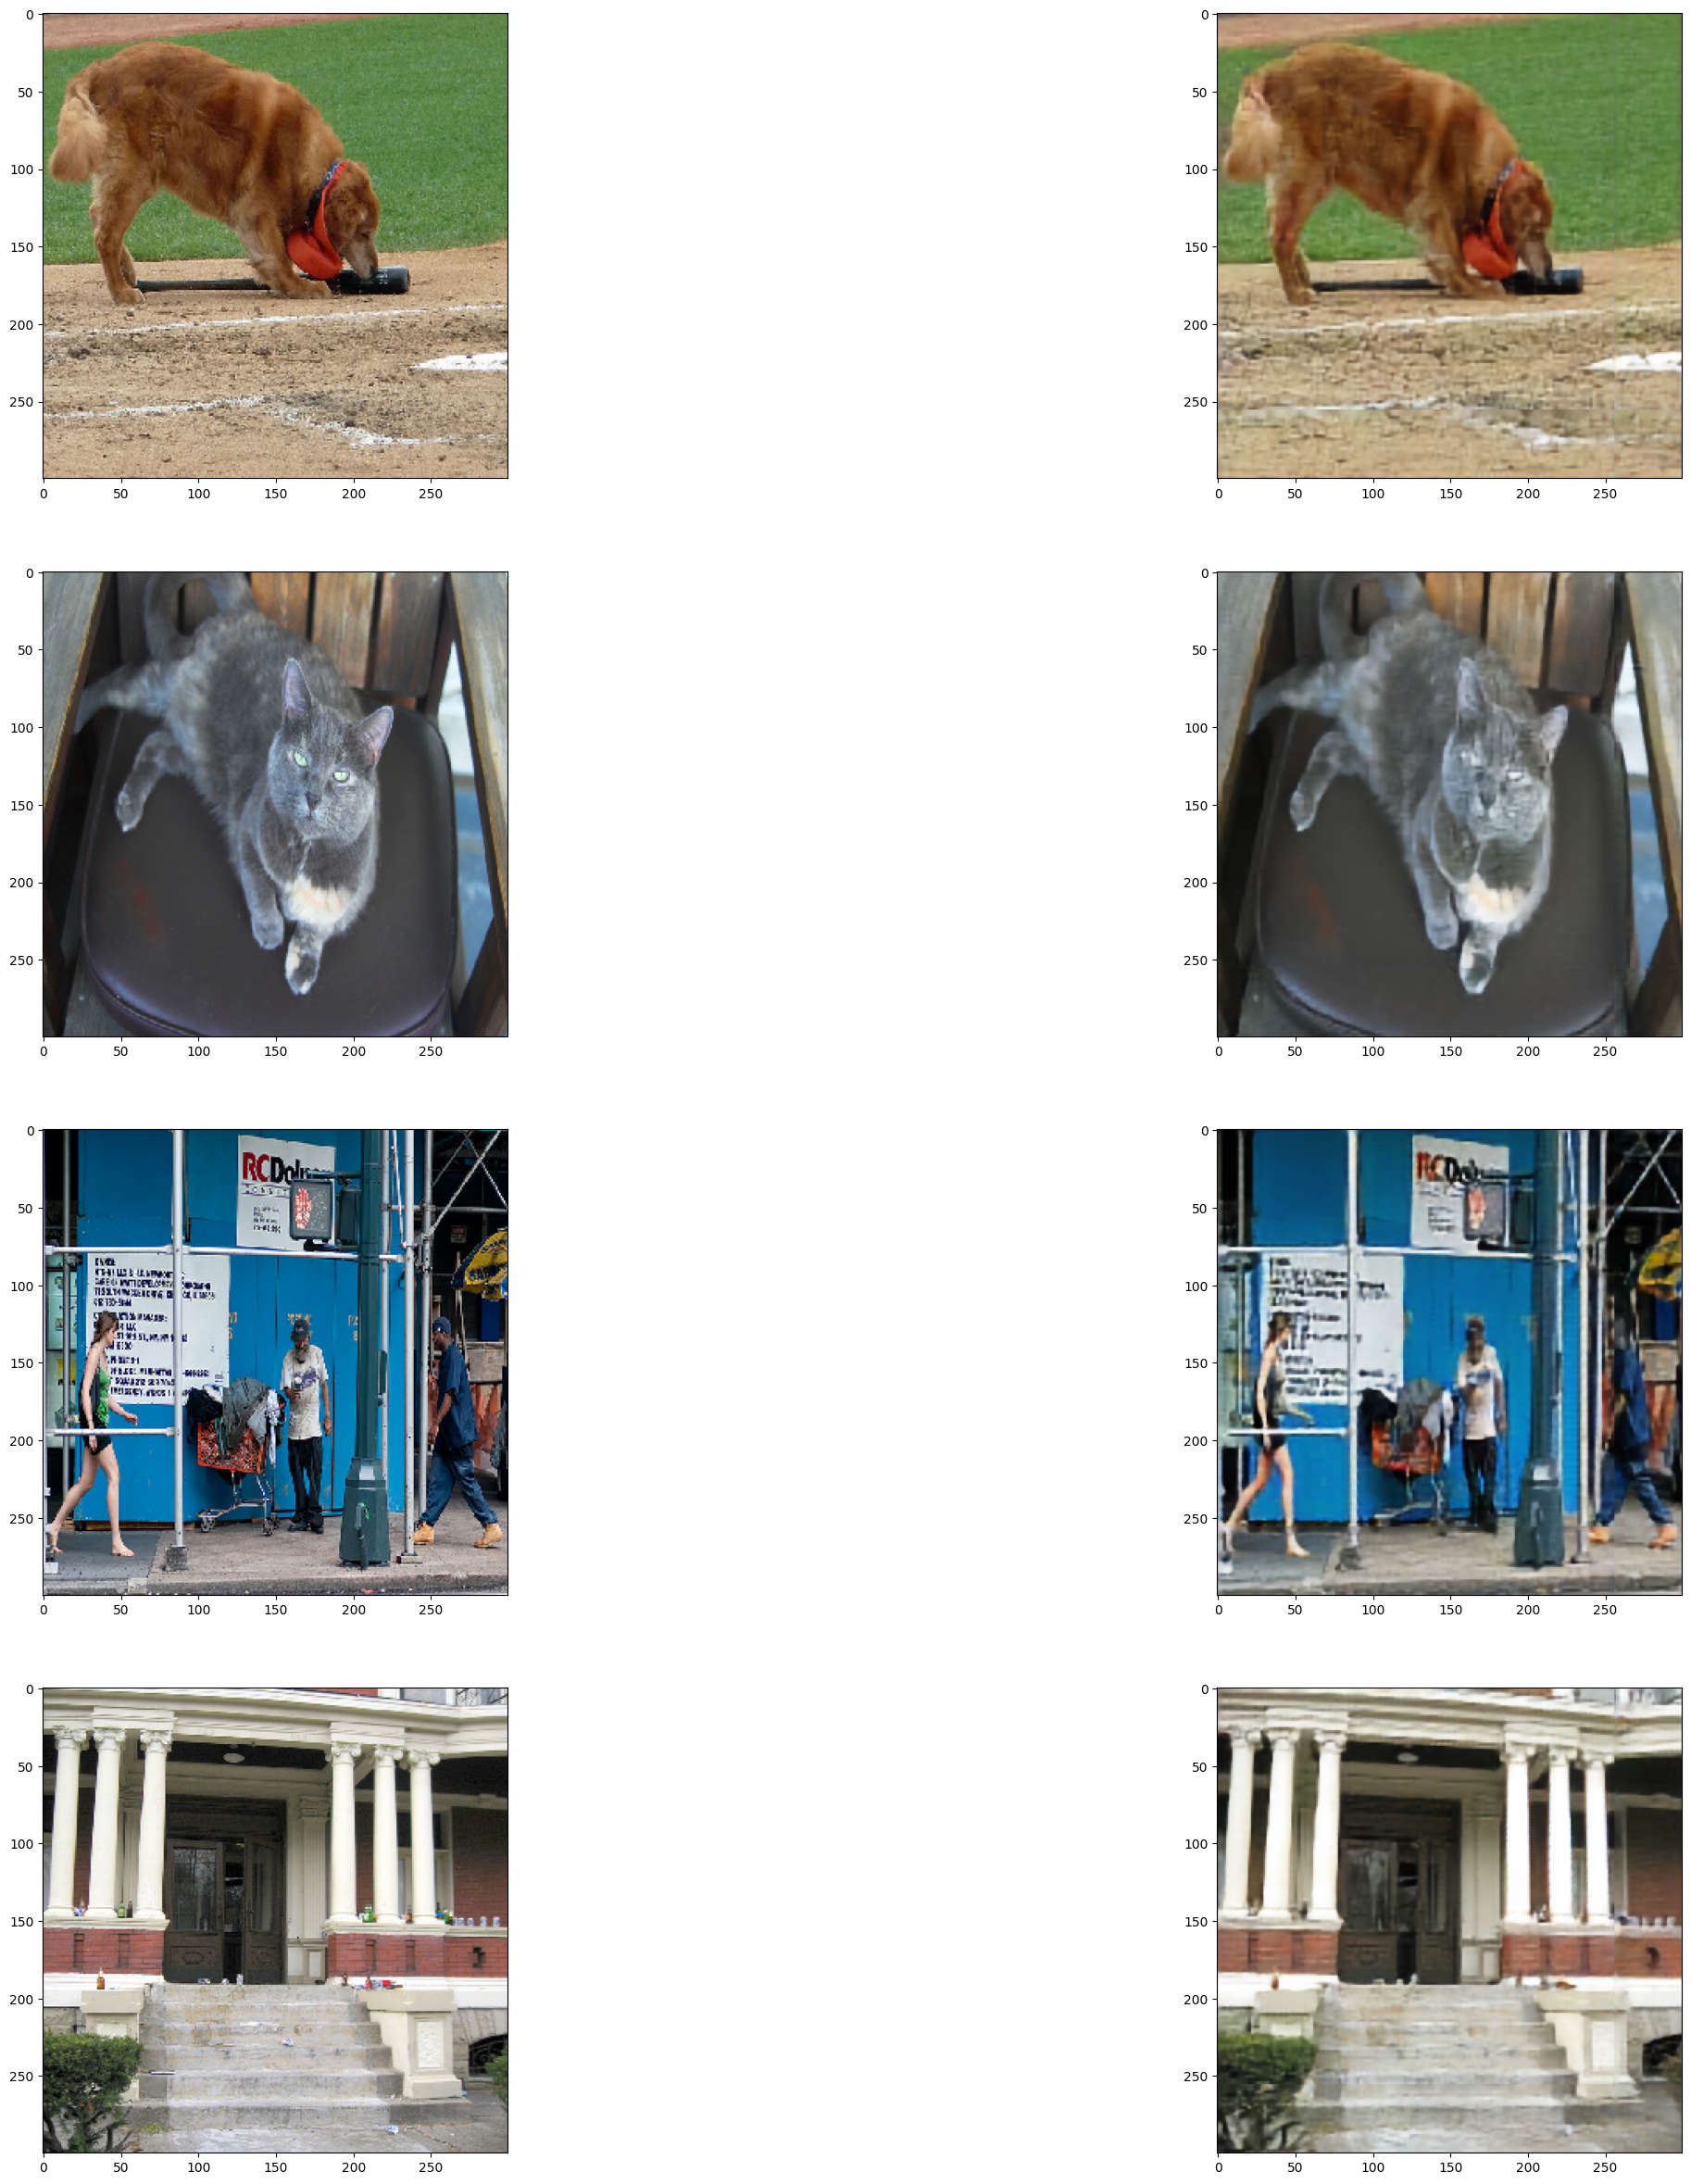

In [25]:
img_size = (image_height_target, image_width_target, 3)

fig = plt.figure(figsize=(30, 30))

ssim_values = []
for i in range(img_number):
    image_slices = test_set[i]

    decoded_slices = autoencoder.predict(image_slices)
    decoded_img = deslice_img(decoded_slices, img_size)
    decoded_img = decenter_img(decoded_img)

    original_image = decenter_img(deslice_img(image_slices, img_size))

    ssim = 1 - tensorflow.image.ssim_multiscale(original_image, decoded_img, 1.0, filter_size=3)
    ssim_values.append(ssim)
    print(ssim.numpy())

    if i < display_img_number:
        plt.subplot(display_img_number, 2, i*2+1)
        plt.imshow(original_image)
        plt.subplot(display_img_number, 2, i*2+2)
        plt.imshow(decoded_img)

print("AVERAGE SSIM: ")
print(np.array(ssim_values).mean())

# rescaled_img = cv2.resize(decenter_img(in_img), (in_img.shape[0] // 3, in_img.shape[1] // 3))

## Visualize the individual tiles

In [ ]:
img_size = (image_height_target, image_width_target, 3)

fig = plt.figure(figsize=(10, 30))

image_slices = test_set[0]
decoded_slices = autoencoder.predict(image_slices)

for i in range(len(decoded_slices)):
    original_image = decenter_img(decoded_slices[i])

    plt.subplot(display_img_number, 2, i*2+1)
    plt.imshow(decenter_img(test_set[0][i]))
    plt.subplot(display_img_number, 2, i*2+2)
    plt.imshow(decenter_img(decoded_slices[i]))

# rescaled_img = cv2.resize(decenter_img(in_img), (in_img.shape[0] // 3, in_img.shape[1] // 3))

## Compare original/decoded/jpeg images

In [28]:
from pathlib import Path
from keras.utils import load_img, save_img, img_to_array

img_size = (image_height_target, image_width_target, 3)

encoder, decoder = split_autoencoder(autoencoder)

output_path = "./output/"
# fig = plt.figure(figsize=(30, 30))

tf.compat.v1.enable_eager_execution()


for i in range(display_img_number):
    print(i)

    path = output_path + str(i) + "_"

    original_path = path + "original.jpg"
    encoded_path = path + "encoded.npz"
    decoded_path = path + "decoded.jpg"
    jpeg_path = path + "jpeg.jpg"

    # Original image
    image_slices = test_set[i]
    original_img = decenter_img(deslice_img(image_slices, img_size))
    original_bgr = original_img.copy()[...,::-1] * 255

    cv2.imwrite(original_path, original_bgr, [int(cv2.IMWRITE_JPEG_QUALITY), 100]) # CHANGED!!!: now the original image is not compressed JPEG instead of keras' solution (Note: this makes the original image large)

    #save_img(original_path, original_img)
    # print("Original min,max,avg",original_img.min(), original_img.mean(), original_img.max())

    original_file_size = Path(original_path).stat().st_size * 8
    bpp_original = float(original_file_size) / (image_height_target * image_width_target)

    # Encoed image
    encoded_slices = encoder.predict(image_slices)
    save_encoded(img_size, encoded_slices, encoded_path)
    # use version loaded from the file, just to prove that it works
    (size, slices) = load_encoded(encoded_path)

    decoded_slices = decoder.predict(slices)
    decoded_img = decenter_img(deslice_img(decoded_slices, size))
    save_img(decoded_path, decoded_img)
    # print("Decoded min,max,avg", decoded_img.min(), decoded_img.mean(), decoded_img.max())

    encoded_file_size = Path(encoded_path).stat().st_size * 8
    bpp = float(encoded_file_size) / (image_height_target * image_width_target)
    ssim = 1 - tensorflow.image.ssim_multiscale(original_img, decoded_img, 1.0, filter_size=3)

    # JPEG compressed
    jpeg_compression_rate = 95
    cv2.imwrite(jpeg_path, original_bgr, [int(cv2.IMWRITE_JPEG_QUALITY), jpeg_compression_rate])

    jpeg_img = img_to_array(load_img(jpeg_path)).astype('float64') / 255
    # print("JPEG min,max,avg", jpeg_img.min(), jpeg_img.mean(), jpeg_img.max())
    # print("OriG min,max,avg",original_img.min(), original_img.mean(), original_img.max())

    jpeg_file_size = Path(jpeg_path).stat().st_size * 8
    bpp_j = float(jpeg_file_size) / (image_height_target * image_width_target)
    ssim_j = 1 - tensorflow.image.ssim_multiscale(original_img, jpeg_img, 1.0, filter_size=3)

    # Results
    print("BPP of original:", bpp_original)
    print("BPP of encoded:", bpp)
    print("SSIM of decoded:", float(ssim))
    print("BPP of jpeg:", bpp_j)
    print("SSIM of jpeg:", float(ssim_j))
    print()

0
1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 218ms/step
BPP of original: 9.061333333333334
BPP of encoded: 2.092888888888889
SSIM of decoded: 0.0758371353149414
BPP of jpeg: 4.9688888888888885
SSIM of jpeg: 0.005011618137359619

1
1/1 [==============================] - 0s 20ms/step
BPP of original: 6.529866666666667
BPP of encoded: 2.0691555555555556
SSIM of decoded: 0.0229988694190979
BPP of jpeg: 3.022222222222222
SSIM of jpeg: 0.006826341152191162

2
1/1 [==============================] - 0s 19ms/step
BPP of original: 9.88871111111111
BPP of encoded: 2.1316444444444445
SSIM of decoded: 0.0704314112663269
BPP of jpeg: 5.491822222222222
SSIM of jpeg: 0.011334121227264404

3
1/1 [==============================] - 0s 18ms/step
BPP of original: 8.433955555555556
BPP of encoded: 2.1183111111111113
SSIM of decoded: 0.04560917615890503
BPP of jpeg: 4.436622222222222
SSIM of jpeg: 0.006773233413696289



# Visualizing layers

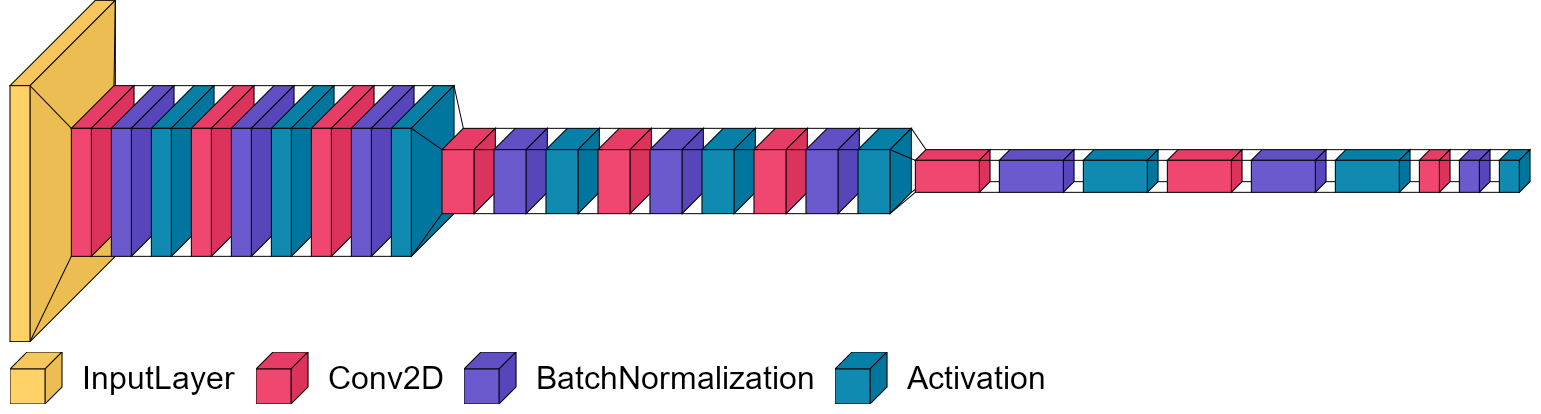

In [14]:
import visualkeras
from PIL import ImageFont
from collections import defaultdict

font = ImageFont.truetype("arial.ttf", 32)

color_map = defaultdict(dict)
color_map[Conv2DTranspose]['fill'] = 'forestgreen'
color_map[BatchNormalization]['fill'] = 'slateblue'

encoder, decoder = split_autoencoder(autoencoder)

visualkeras.layered_view(encoder, legend=True, font=font, draw_volume=True, spacing=20, scale_xy=1, scale_z=1, color_map=color_map)#, type_ignore=[BatchNormalization, Activation])

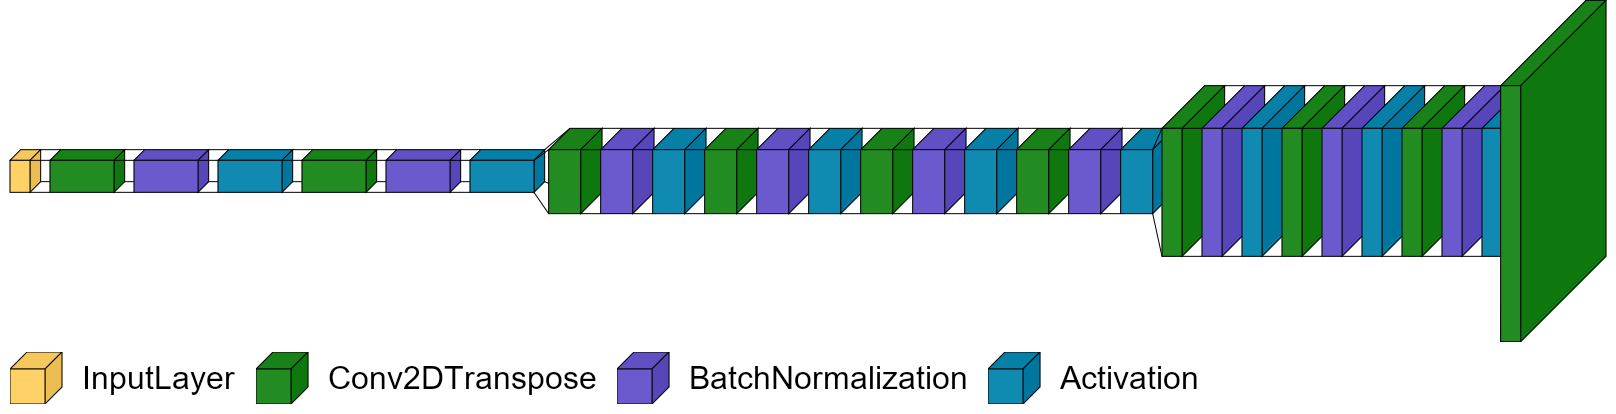

In [15]:
visualkeras.layered_view(decoder, legend=True, font=font, draw_volume=True, spacing=20, scale_xy=1, scale_z=1, color_map=color_map)#, type_ignore=[Activation, BatchNormalization])

In [20]:
from keras_sequential_ascii import keras2ascii
keras2ascii(autoencoder)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####    256  256    3
              Conv2D    \|/  -------------------       448     0.2%
                       #####    128  128   16
  BatchNormalization    μ|σ  -------------------        64     0.0%
          leaky_relu   #####    128  128   16
              Conv2D    \|/  -------------------      2320     1.2%
                       #####    128  128   16
  BatchNormalization    μ|σ  -------------------        64     0.0%
          leaky_relu   #####    128  128   16
              Conv2D    \|/  -------------------      2320     1.2%
                       #####    128  128   16
  BatchNormalization    μ|σ  -------------------        64     0.0%
          leaky_relu   #####    128  128   16
              Conv2D    \|/  -------------------      4640     2.5%
                       #####     64   64   32
  BatchNormalization    μ|σ  -------------------       128     0.1%
          leak